In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
import gc

from tslearn.piecewise import PiecewiseAggregateApproximation
from IPython.display import Audio
from tqdm.notebook import tqdm

from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = np.load("../DATASETS/TimeSeriesTrimmed/X_train.npy")
y_train = pd.read_csv("../DATASETS/TimeSeriesTrimmed/y_train.csv")

X_test = np.load("../DATASETS/TimeSeriesTrimmed/X_test.npy")
y_test = pd.read_csv("../DATASETS/TimeSeriesTrimmed/y_test.csv")

# np.nan_to_num(X_train,copy=False)
# np.nan_to_num(X_test,copy=False)
print(X_train.shape,X_test.shape)

(1828, 243200) (624, 243200)


## Random sampling

In [40]:
sample_idxs_train=y_train.groupby('emotion')['filename'].apply(lambda s: s.sample(25)).index.get_level_values(1)
sample_idxs_test=y_test.groupby('emotion')['filename'].apply(lambda s: s.sample(10)).index.get_level_values(1)

In [41]:
X_train=X_train[sample_idxs_train]
y_train=y_train.iloc[sample_idxs_train]

X_test=X_test[sample_idxs_test]
y_test=y_test.iloc[sample_idxs_test]

print(X_train.shape,X_test.shape)

(200, 243200) (80, 243200)


## Appro

In [3]:
n_paa_segments = 2000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)

X_train_paa = list()
for ts in tqdm(X_train):
    ts = ts[~np.isnan(ts)].reshape(1,-1)
    ts_paa = paa.fit_transform(ts).squeeze()
    X_train_paa.append(ts_paa)
    
X_test_paa = list()
for ts in tqdm(X_test):
    ts = ts[~np.isnan(ts)].reshape(1,-1)
    ts_paa = paa.fit_transform(ts).squeeze()
    X_test_paa.append(ts_paa)
    
X_train=np.array(X_train_paa)
X_test=np.array(X_test_paa)
del X_train_paa,X_test_paa
gc.collect()

  0%|          | 0/1828 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

68

In [4]:
emotion_mapper = {"neutral":0, "calm":1, "happy":2, "sad":3, "angry":4, "fearful":5, "disgust":6, "surprised":7}
y_train = y_train["emotion"].replace(emotion_mapper)
y_test = y_test["emotion"].replace(emotion_mapper)

# Shaplet Classifiers

## Brute Force Approach

In [44]:
from pyts.transformation import ShapeletTransform

In [45]:
# Shapelet transformation
st = ShapeletTransform(n_shapelets=6,
                        window_sizes=[100],
                        sort=True,
                        n_jobs=-1,
                        verbose=50)
X_new = st.fit_transform(X_train, y_train)
X_test_new = st.transform(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

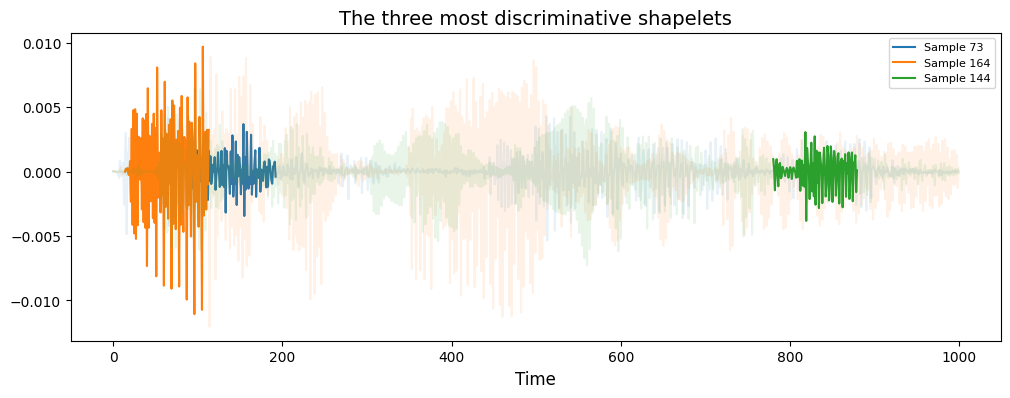

In [48]:
plt.figure(figsize=(12, 4))
for i, index in enumerate(st.indices_[:3]):
    idx, start, end = index
    plt.plot(X_train[idx], color='C{}'.format(i),alpha=0.1)
    plt.plot(np.arange(start, end), X_train[idx, start:end],lw=1.5, color='C{}'.format(i),label='Sample {}'.format(idx))

plt.xlabel('Time', fontsize=12)
plt.title('The three most discriminative shapelets', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.show()

In [12]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_new, y_train)

y_pred = clf.predict(X_test_new)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.1875
F1-score [0.23529412 0.5        0.09090909 0.21052632 0.31578947 0.14285714
 0.1        0.        ]
              precision    recall  f1-score   support

           0       0.29      0.20      0.24        10
           1       0.67      0.40      0.50        10
           2       0.08      0.10      0.09        10
           3       0.22      0.20      0.21        10
           4       0.33      0.30      0.32        10
           5       0.11      0.20      0.14        10
           6       0.10      0.10      0.10        10
           7       0.00      0.00      0.00        10

    accuracy                           0.19        80
   macro avg       0.23      0.19      0.20        80
weighted avg       0.23      0.19      0.20        80



## Learning-based Approach

In [5]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

In [6]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 1828
ts_sz 2000
n_classes 8
shapelet_sizes {200: 7}


In [7]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=10,
                        verbose=1,)

In [8]:
shp_clf.fit(X_train, y_train)
y_pred = shp_clf.predict(X_test)

Epoch 1/10
8/8 [==============================] - 2s 136ms/step - loss: 2.1554 - categorical_accuracy: 0.1532 - categorical_crossentropy: 2.0785
Epoch 2/10
8/8 [==============================] - 1s 131ms/step - loss: 2.1544 - categorical_accuracy: 0.1532 - categorical_crossentropy: 2.0778
Epoch 3/10
8/8 [==============================] - 1s 139ms/step - loss: 2.1534 - categorical_accuracy: 0.1532 - categorical_crossentropy: 2.0770
Epoch 4/10
8/8 [==============================] - 1s 142ms/step - loss: 2.1525 - categorical_accuracy: 0.1532 - categorical_crossentropy: 2.0763
Epoch 5/10
8/8 [==============================] - 1s 141ms/step - loss: 2.1514 - categorical_accuracy: 0.1532 - categorical_crossentropy: 2.0755
Epoch 6/10
8/8 [==============================] - 1s 141ms/step - loss: 2.1504 - categorical_accuracy: 0.1532 - categorical_crossentropy: 2.0747
Epoch 7/10
8/8 [==============================] - 1s 143ms/step - loss: 2.1494 - categorical_accuracy: 0.1532 - categorical_crosse

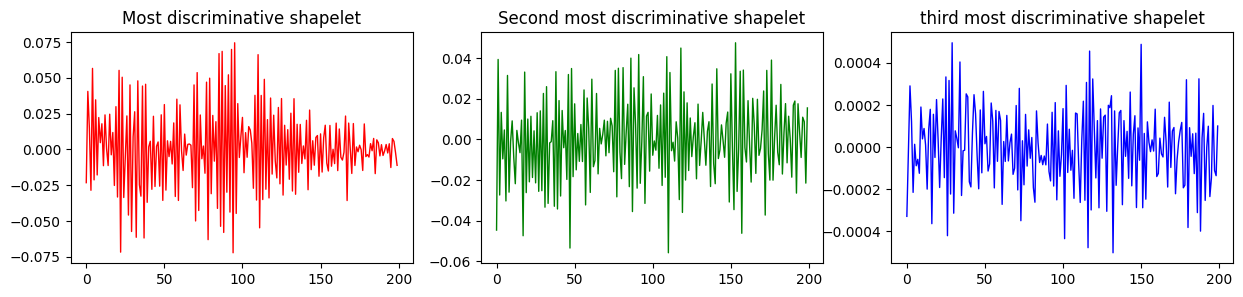

In [27]:
fig, axs = plt.subplots(ncols=3, sharex=True,figsize=(15,3))
axs[0].set_title("Most discriminative shapelet")
axs[0].plot(shp_clf.shapelets_[0],color="red",label="shapelet",lw=1)
axs[1].set_title("Second most discriminative shapelet")
axs[1].plot(shp_clf.shapelets_[1],color="green",label="shapelet",lw=1)
axs[2].set_title("third most discriminative shapelet")
axs[2].plot(shp_clf.shapelets_[2],color="blue",label="shapelet",lw=1)

In [10]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.15384615384615385
F1-score [0.         0.         0.         0.         0.26666667 0.
 0.         0.        ]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.00      0.00      0.00        96
           2       0.00      0.00      0.00        96
           3       0.00      0.00      0.00        96
           4       0.15      1.00      0.27        96
           5       0.00      0.00      0.00        96
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        48

    accuracy                           0.15       624
   macro avg       0.02      0.12      0.03       624
weighted avg       0.02      0.15      0.04       624



## Shaplet-distances-based Classifier

In [11]:
X_train2 = shp_clf.transform(X_train)
X_test2 = shp_clf.transform(X_test)

3/3 [==============================] - 0s 100ms/step


In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
clf = KNeighborsClassifier(n_neighbors=8, weights='distance')
clf.fit(X_train2, y_train)
y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.21955128205128205
F1-score [0.08888889 0.37837838 0.18536585 0.19047619 0.23469388 0.23036649
 0.14634146 0.08219178]
              precision    recall  f1-score   support

           0       0.10      0.08      0.09        48
           1       0.33      0.44      0.38        96
           2       0.17      0.20      0.19        96
           3       0.19      0.19      0.19        96
           4       0.23      0.24      0.23        96
           5       0.23      0.23      0.23        96
           6       0.18      0.12      0.15        48
           7       0.12      0.06      0.08        48

    accuracy                           0.22       624
   macro avg       0.19      0.20      0.19       624
weighted avg       0.21      0.22      0.21       624



In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.2724358974358974
F1-score [0.26966292 0.38613861 0.24074074 0.2994012  0.25984252 0.24516129
 0.27272727 0.1038961 ]
              precision    recall  f1-score   support

           0       0.29      0.25      0.27        48
           1       0.37      0.41      0.39        96
           2       0.22      0.27      0.24        96
           3       0.35      0.26      0.30        96
           4       0.21      0.34      0.26        96
           5       0.32      0.20      0.25        96
           6       0.30      0.25      0.27        48
           7       0.14      0.08      0.10        48

    accuracy                           0.27       624
   macro avg       0.27      0.26      0.26       624
weighted avg       0.28      0.27      0.27       624



In [18]:
X_train2[0]

array([7.97220215e-04, 4.31962573e-04, 3.75437388e-08, 4.68216324e-03,
       3.49803157e-02, 3.22048087e-03, 1.36856055e-02], dtype=float32)